In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
import sys
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM2D import TMCRBM2D
from TMCRBM import TMCRBM
from RBM import RBM
import gzip
import pickle
import functions
import h5py


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [2]:
f = gzip.open('../dataset/mnist.pkl.gz', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
p = u.load()
train_set, _, _ = p
data = torch.as_tensor(train_set[0][:10000,:].T, device = device, dtype = dtype)


In [3]:
f_name_tmc = "../model/TMC1D/MNIST/AllParametersTMCRBM_MNIST2_NGibbs_50_Nh100_Nv784_Nmb200_Nepoch1000_lr_0.01_N20000_Npoint1000_Nchain15.h5"
f_tmc = h5py.File(f_name_tmc, "r")
alltimes = []
for t in f_tmc['alltime'][:]:
    if 'W'+str(t) in f_tmc:
        alltimes.append(t)
alltimes = np.array(alltimes)

In [14]:
lr = 0.01
l2 = 0
NGibbs = 10
annSteps = 0
mb_s = 500
num_pcd = 500
Nh = torch.tensor(f_tmc['W0']).shape[0]
Nv = data.shape[0]
print(Nh)
ep_max = 100

RBM_TMC = TMCRBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
                direction=2,
				num_pcd=num_pcd)
_, _, V = torch.svd(RBM_TMC.W)

t = alltimes[-1]
RBM_TMC.W = torch.tensor(f_tmc['W'+str(t)], device = RBM_TMC.device)
RBM_TMC.hbias = torch.tensor(f_tmc['hbias'+str(t)], device = RBM_TMC.device)
RBM_TMC.vbias = torch.tensor(f_tmc['vbias'+str(t)], device = RBM_TMC.device)
_, S_tmc, V_tmc = torch.svd(RBM_TMC.W)

100


In [5]:
alltimes

array([   0,    1,    2,    3,    4,    5,    6,    8,    9,   10,   12,
         14,   15,   16,   18,   22,   24,   25,   26,   28,   32,   38,
         41,   42,   43,   45,   48,   49,   55,   65,   69,   70,   71,
         73,   77,   82,   83,   93,  110,  118,  119,  120,  122,  126,
        132,  138,  142,  159,  187,  201,  202,  203,  205,  209,  215,
        225,  236,  242,  270,  319,  342,  343,  344,  346,  350,  356,
        366,  383,  402,  411,  460,  543,  582,  583,  584,  586,  590,
        596,  606,  623,  651,  684,  700,  783,  924,  990,  991,  992,
        994,  998, 1004, 1014, 1031, 1059, 1108, 1164, 1191, 1332, 1572,
       1683, 1684, 1685, 1687, 1691, 1697, 1707, 1724, 1752, 1801, 1884,
       1980, 2025, 2265, 2673, 2862, 2863, 2864, 2866, 2870, 2876, 2886,
       2903, 2931, 2980, 3063, 3204, 3366, 3444, 3852, 4545, 4866, 4867,
       4868, 4870, 4874, 4880, 4890, 4907, 4935, 4984, 5067, 5208, 5448,
       5724])

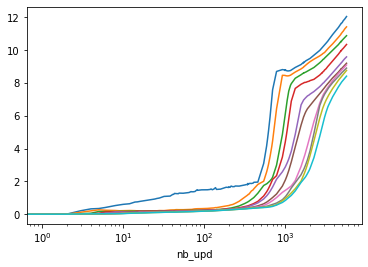

In [8]:
nvalsing = 10
S = torch.zeros(nvalsing, len(alltimes), device = device)
for i in range(len(alltimes)):
    t = alltimes[i]
    _, tmpS, tmpV = torch.svd(torch.tensor(f_tmc['W'+str(t)], device = device))
    if torch.mean(tmpV[:,0])<0:
        tmpV = -tmpV
    #plt.plot(tmpV[:,0].cpu(), zorder=0)
    S[:,i] = tmpS[:nvalsing]
#plt.hlines(1/np.sqrt(1000), 0, 1000, color = 'black', zorder=10)
plt.plot(alltimes,S.T.cpu())
plt.semilogx()
plt.xlabel("nb_upd");


In [9]:
nb_chain = 10 # Nb de chaines pour chaque w_hat
it_mcmc = 200 # Nb it_mcmc pour chaque chaine
it_mean = 100 # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 20000 # Contrainte
nb_point = 15000 # Nb de points de discrétisation pour w_hat
proj_data =torch.mm(data.T, V_tmc).cpu()/RBM_TMC.Nv**0.5
xmin = torch.min(proj_data[:,0])-0.2
xmax = torch.max(proj_data[:,0])+0.2
border_length=0.1


In [22]:
p_m, grad_pot, potential, w_hat_b = functions.ComputeProbabilityTMC1D(RBM_TMC, data.T, nb_chain, it_mcmc, it_mean, N, nb_point, border_length, V_tmc, device)

w_hat_b = w_hat_b.cpu()
p_m = p_m.cpu()

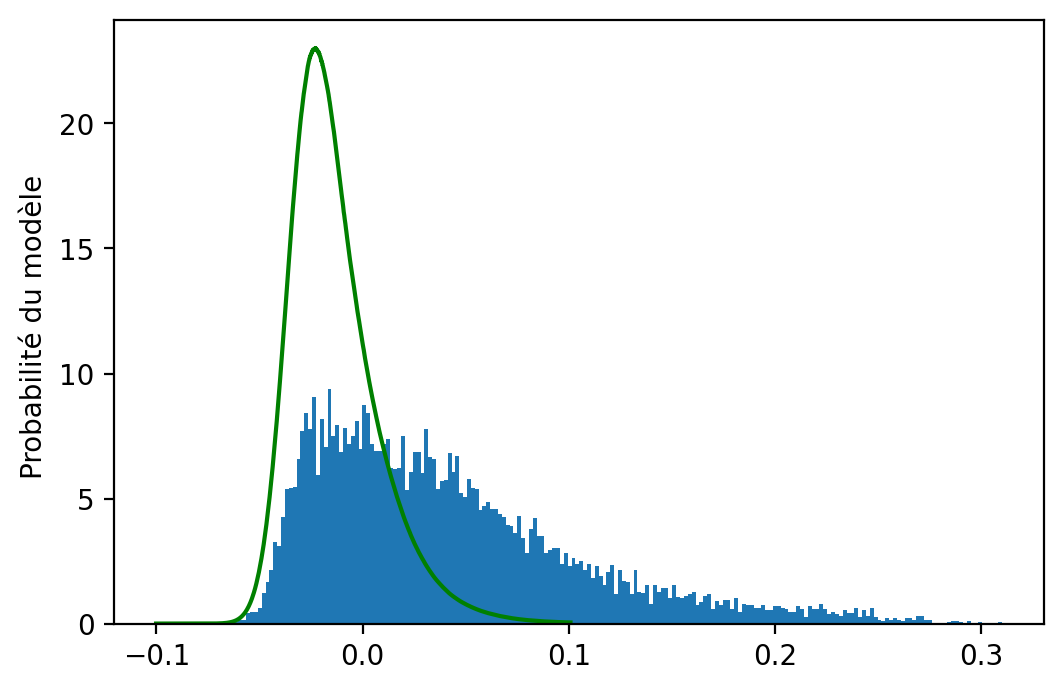

In [23]:
plt.figure(dpi=200)
plt.hist(proj_data[:,2].numpy(), label = 'jeu de données', density=True, bins=200)
#plt.hist(gen_data, bins = 200, density=True)
#plt.hist(proj_gen[:,0], label = 'données générées', density=True, bins=200)
plt.plot(w_hat_b[1:], p_m, color = "green", label = "probabilité du modèle")
plt.ylabel("Probabilité du modèle ")
plt.legend
plt.show()

In [18]:
times_gen_tmc = np.array([110,783,2025,5208])
all_mi_tmc = []
for t in times_gen_tmc:
    print(t)
    RBM_TMC.W = torch.tensor(f_tmc['W'+str(t)], device = RBM_TMC.device)
    RBM_TMC.vbias = torch.tensor(f_tmc['vbias'+str(t)], device = RBM_TMC.device)
    RBM_TMC.hbias = torch.tensor(f_tmc['hbias'+str(t)], device = RBM_TMC.device)
    _, S_tmc, V_tmc = torch.svd(RBM_TMC.W)
    p_m, _, _, w_hat_b = functions.ComputeProbabilityTMC1D(RBM_TMC, data.T, nb_chain, 50, 20, N, nb_point, border_length, V_tmc, device)
    si, mi = functions.genDataTMC1D(RBM_TMC, p_m, w_hat_b, 100, N, V_tmc, it_mcmc=30)
    all_mi_tmc.append(mi)

110
783
2025
5208


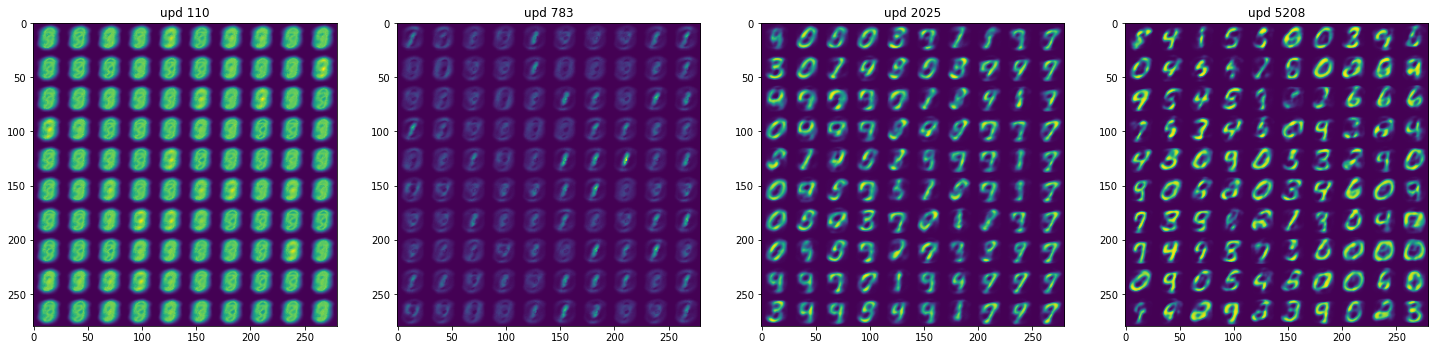

In [19]:
fig,ax = plt.subplots(1,len(times_gen_tmc),figsize=(25,10))
for idx in range(len(times_gen_tmc)):
    Im = RBM_TMC.ImConcat(all_mi_tmc[idx].t(),sx=28,sy=28,ncol=10,nrow=10,ch=1)
    ax[idx].imshow(Im.cpu())
    ax[idx].set_title("upd "+str(times_gen_tmc[idx]))


In [24]:
alltimes

array([   0,    1,    2,    3,    4,    5,    6,    8,    9,   10,   12,
         14,   15,   16,   18,   22,   24,   25,   26,   28,   32,   38,
         41,   42,   43,   45,   48,   49,   55,   65,   69,   70,   71,
         73,   77,   82,   83,   93,  110,  118,  119,  120,  122,  126,
        132,  138,  142,  159,  187,  201,  202,  203,  205,  209,  215,
        225,  236,  242,  270,  319,  342,  343,  344,  346,  350,  356,
        366,  383,  402,  411,  460,  543,  582,  583,  584,  586,  590,
        596,  606,  623,  651,  684,  700,  783,  924,  990,  991,  992,
        994,  998, 1004, 1014, 1031, 1059, 1108, 1164, 1191, 1332, 1572,
       1683, 1684, 1685, 1687, 1691, 1697, 1707, 1724, 1752, 1801, 1884,
       1980, 2025, 2265, 2673, 2862, 2863, 2864, 2866, 2870, 2876, 2886,
       2903, 2931, 2980, 3063, 3204, 3366, 3444, 3852, 4545, 4866, 4867,
       4868, 4870, 4874, 4880, 4890, 4907, 4935, 4984, 5067, 5208, 5448,
       5724])